# Bias Removal

Climate models can have biases relative to different verification datasets. Commonly, biases are removed by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

---

The select from following methods by specifying `how` in [HindcastEnsemble.remove_bias](api/climpred.classes.HindcastEnsemble.remove_bias.html#climpred.classes.HindcastEnsemble.remove_bias):

- ``how="additive_mean"``: correcting the mean forecast additively
- ``how="multiplicative_mean"``: correcting the mean forecast multiplicatively
- ``how="multiplicative_std"``: correcting the standard deviation multiplicatively

Wrapped from the github package [bias_correction](https://github.com/pankajkarman/bias_correction/blob/master/bias_correction.py):

- ``how="modified_quantile"``: [Reference](https://www.sciencedirect.com/science/article/abs/pii/S0034425716302000?via%3Dihub)
- ``how="basic_quantile"``: [Reference](https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/joc.2168)
- ``how="gamma_mapping"``: [Reference](https://www.hydrol-earth-syst-sci.net/21/2649/2017)
- ``how="normal_mapping"``: [Reference](https://www.hydrol-earth-syst-sci.net/21/2649/2017)

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble

<IPython.core.display.Javascript object>

In [3]:
init = climpred.tutorial.load_dataset("NMME_hindcast_Nino34_sst")
obs = climpred.tutorial.load_dataset("NMME_OIv2_Nino34_sst")
v = "sst"

<IPython.core.display.Javascript object>

/Users/aaron.spring/Coding/climpred/climpred/checks.py:237: UserWarning: Did not find dimension "init", but renamed dimension S with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:237: UserWarning: Did not find dimension "member", but renamed dimension M with CF-complying standard_name "realization" to member.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:237: UserWarning: Did not find dimension "lead", but renamed dimension L with CF-complying standard_name "forecast_period" to lead.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='Sea Surface Temperature\n[Celsius_scale]'>

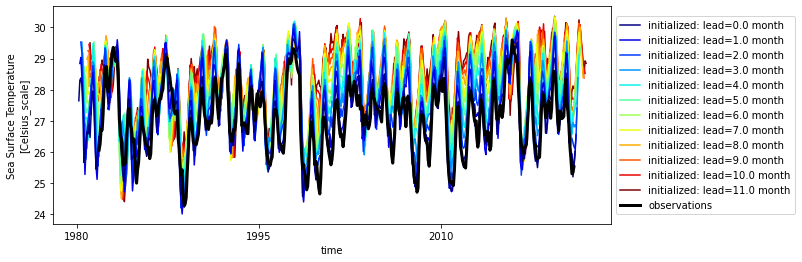

<IPython.core.display.Javascript object>

In [4]:
hindcast = HindcastEnsemble(init.sel(model="GFDL-CM2p5-FLOR-A06")).add_observations(obs)
hindcast.plot()

The warming of the `observations` is similar to `initialized`.

## Additive mean bias removal

Typically, bias depends on lead-time and therefore should therefore also be removed depending on `lead`.

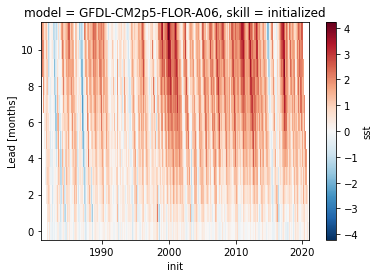

<IPython.core.display.Javascript object>

In [5]:
bias = hindcast.verify(
    metric="additive_bias", comparison="e2o", dim=[], alignment="same_verifs"
)

bias[v].plot()

In [6]:
# group bias by seasonality
seasonality = climpred.options.OPTIONS["seasonality"]
seasonality

'month'

<IPython.core.display.Javascript object>

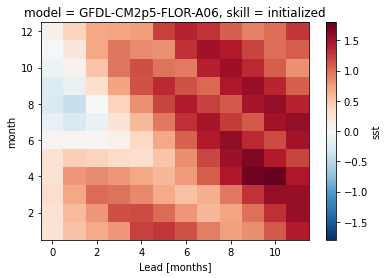

<IPython.core.display.Javascript object>

In [7]:
bias.groupby(f"init.{seasonality}").mean()[v].plot()

An initial warm bias develops into a cold bias, especially in winter.

## `train_test_split`

[Risbey et al. 2021](http://www.nature.com/articles/s41467-021-23771-z) demonstrate how important a clean separation of a `train` and a `test` period is for bias reduction. 

Implemented `train_test_split`s in `climpred`:

- `unfair`: completely overlapping `train` and `test` (climpred default)
- `unfair-cv`: overlapping `train` and `test` except for current `init`, which is [left out](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) (set `cv='LOO'`)
- `fair`: no overlap between `train` and `test` (recommended)

In [8]:
metric_kwargs = dict(
    metric="rmse", alignment="same_verifs", dim="init", comparison="e2o", skipna=True
)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Sea Surface Temperature\n[Celsius_scale]'>

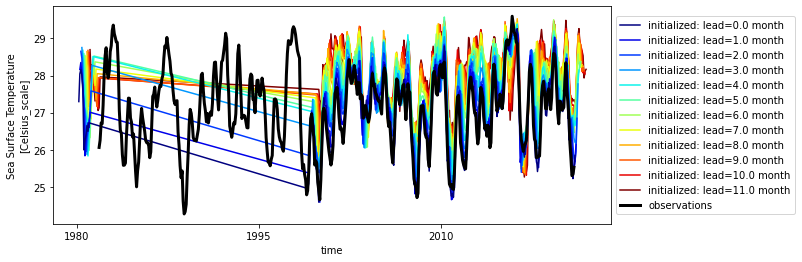

<IPython.core.display.Javascript object>

In [9]:
# fair calculates bias for train_time/train_init and drops these data from hindcast
hindcast.remove_bias(
    how="additive_mean",
    alignment=metric_kwargs["alignment"],
    train_test_split="fair",
    train_time=slice("1982", "1998"),
).plot()

Text(0.5, 1.0, 'NMME GFDL-CM2p5-FLOR-A06 Nino3.4 SST RMSE')

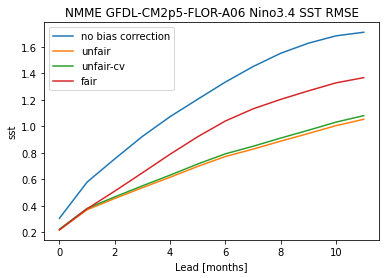

<IPython.core.display.Javascript object>

In [10]:
hindcast.verify(**metric_kwargs)[v].plot(label="no bias correction")
train_test_split = ["unfair", "unfair-cv", "fair"]

hindcast.remove_bias(
    how="additive_mean", alignment=metric_kwargs["alignment"], train_test_split="unfair"
).verify(**metric_kwargs)[v].plot(label="unfair")

hindcast.remove_bias(
    how="additive_mean",
    alignment=metric_kwargs["alignment"],
    train_test_split="unfair-cv",
    cv="LOO",
).verify(**metric_kwargs)[v].plot(label="unfair-cv")

hindcast.remove_bias(
    how="additive_mean",
    alignment=metric_kwargs["alignment"],
    train_test_split="fair",
    train_time=slice("1982", "1998"),
).verify(**metric_kwargs)[v].plot(label="fair")


plt.legend()
plt.title(
    f"NMME {hindcast.coords['model'].values} Nino3.4 SST {metric_kwargs['metric'].upper()}"
)